# Implementação de métodos de detecção de picos em séries temporais

Baseado nos métodos propostos em "Simple Algorithms for Peak Detection in Time-Series" (Girish Palshikar, 2009).

In [42]:
# Bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import importlib
import scienceplots
from sklearn.preprocessing import normalize
from IPython.display import clear_output
import sys
from sklearn.neighbors import KernelDensity

# Funções utilitárias
#
# Adiciona o caminho para a pasta em que os arquivos utilitários estão
sys.path.insert(1, '/home/yanvgf/Projetos/litc/ihm/previsao-flotacao/novos-dados/git-workspace/Fase3/Utils')
#
import NomesDasVariaveis
import pre_processing
import models
import analysis

# Atualiza bibliotecas sem precisar reiniciar o kernel
importlib.reload(NomesDasVariaveis)
importlib.reload(pre_processing)
importlib.reload(analysis)
importlib.reload(models)

# Configuração dos plots
plt.style.use(['grid', 'notebook', 'science'])
plt.rcParams["figure.figsize"] = (10,6)

In [43]:
# SAÍDAS
saidas_L1 = ['4_ALZ1VI_QQ_GLOBAL_SiO2', '4_ALZ1VI_QQ_GLOBAL_Fe', '4_RJT1VI_QQ_GLOBAL_Fe']
saidas_L2 = ['4_ALZ2VI_QQ_GLOBAL_SiO2', '4_ALZ2VI_QQ_GLOBAL_Fe', '4_RJT2VI_QQ_GLOBAL_Fe']

# SELECIONE A SAÍDA AQUI
target = saidas_L1[0]

## Funções criadas

In [48]:
def s1_metric(data, k):
    """Métrica S1 do artigo (média entre a máxima distância de um ponto até seus k vizinhos à direita e a máxima à esquerda)

    Input:
        data (pd.DataFrame): dataframe com os dados a serem classificados em pico ou não\n
        k (int): número de vizinhos a ser considerado (no artigo, é sugerido utilizar um valor com sentido, ex.: amostras referentes a 1 dia)\n
    
    Output:
        s1 (pd.DataFrame): série com os valores da métrica S1 para cada ponto
    """
    
    s1 = np.zeros(data.shape[0])
    
    # Para cada amostra em data, calcula a diferença entre seu valor e seus k vizinhos à direita e à esquerda
    for idx in range(data.shape[0]):
        max_right = np.max([data.iloc[idx,:].values[0] - data.iloc[idx+k_i+1,:].values[0]
                        if idx+k_i+1 < data.shape[0] else 0
                        for k_i in range(k)])
        max_left = np.max([data.iloc[idx,:].values[0] - data.iloc[idx-(k_i+1),:].values[0] 
                        if idx-(k_i+1) >= 0 else 0
                        for k_i in range(k)])
        s1[idx] = (max_right + max_left)/2
        
    return pd.DataFrame(s1)

####################################################################################################

def s2_metric(data, k):
    """Métrica S2 do artigo (média entre a distância média de um ponto até seus k vizinhos à direita e a máxima à esquerda)

    Input:
        data (pd.DataFrame): dataframe com os dados a serem classificados em pico ou não\n
        k (int): número de vizinhos a ser considerado (no artigo, é sugerido utilizar um valor com sentido, ex.: amostras referentes a 1 dia)\n
    
    Output:
        s2 (pd.DataFrame): série com os valores da métrica S2 para cada ponto
    """
    
    s2 = np.zeros(data.shape[0])
    
    # Para cada amostra em data, calcula a diferença entre seu valor e seus k vizinhos à direita e à esquerda
    for idx in range(data.shape[0]):
        mean_right = np.mean([data.iloc[idx,:].values[0] - data.iloc[idx+k_i+1,:].values[0]
                            if idx+k_i+1 < data.shape[0] else 0
                            for k_i in range(k)])
        mean_left = np.mean([data.iloc[idx,:].values[0] - data.iloc[idx-(k_i+1),:].values[0] 
                            if idx-(k_i+1) >= 0 else 0
                            for k_i in range(k)])
        s2[idx] = (mean_right + mean_left)/2
        
    return pd.DataFrame(s2)

####################################################################################################

def s3_metric(data, k):
    """Métrica S3 do artigo (média entre a distância média de um ponto até o ponto médio de seus k vizinhos à direita e a máxima à esquerda)

    Input:
        data (pd.DataFrame): dataframe com os dados a serem classificados em pico ou não\n
        k (int): número de vizinhos a ser considerado (no artigo, é sugerido utilizar um valor com sentido, ex.: amostras referentes a 1 dia)\n
    
    Output:
        S3 (pd.DataFrame): série com os valores da métrica S3 para cada ponto
    """
    
    s3 = np.zeros(data.shape[0])
    
    # Para cada amostra em data, calcula a diferença entre seu valor e seus k vizinhos à direita e à esquerda
    for idx in range(data.shape[0]):
        diff_right = data.iloc[idx,:].values[0] - np.mean([data.iloc[idx+k_i+1,:].values[0]
                                                        if idx+k_i+1 < data.shape[0] else 0
                                                        for k_i in range(k)])
        diff_left = data.iloc[idx,:].values[0] - np.mean([data.iloc[idx-(k_i+1),:].values[0] 
                                                        if idx-(k_i+1) >= 0 else 0
                                                        for k_i in range(k)])
        s3[idx] = (diff_right + diff_left)/2
        
    return pd.DataFrame(s3)

####################################################################################################

def get_entropy(data, kde_estimator):
    """Calcula a entropia de Shannon dos dados de entrada
    
    Input:
        data (pd.DataFrame): dataframe com os dados a serem calculados a entropia\n
        kde_estimator (sklearn.neighbors.KernelDensity): estimador de densidade do sklearn\n
    
    Output:
        entropy (float): valor da entropia de Shannon
    """

    # Ajusta estimador aos dados
    kde_estimator.fit(data.values)

    # Método score_samples retorna o logaritmo da densidade de probabilidade dos dados
    log_dens = kde_estimator.score_samples(data.values)
    
    # A entropia envolve a estimação da densidade de probabilidade dos dados
    entropy = -np.sum([ np.exp(log_dens) * log_dens ])
    
    return entropy


def s4_metric(data, k, bandwidth, kde_kernel='gaussian'):
    """Métrica S4 do artigo (diferença de entropia em uma janela antes e depois de adicionar uma amostra)
    
    Input:
        data (pd.DataFrame): dataframe com os dados a serem classificados em pico ou não\n
        k (int): número de vizinhos a ser considerado (no artigo, é sugerido utilizar um valor com sentido, ex.: amostras referentes a 1 dia)\n
        bandwidth (int): largura da janela de estimação da densidade de probabilidade\n
        kd_kernel (str, default='gaussian'): kernel a ser utilizado no KDE (gaussian, epanechnikov)\n
    
    Output:
        s4 (pd.DataFrame): série com os valores da métrica S4 para cada ponto
    """
    
    s4 = []
    
    # Crie uma instância do KernelDensity
    kde_estimator = KernelDensity(bandwidth=bandwidth, kernel=kde_kernel)
    
    for idx in range(data.shape[0]):
        
        # Evita problema de janela com índices negativos ou maiores que o tamanho do dataframe
        left_window_index = idx-k
        if left_window_index < 0:
            left_window_index = 0
        #
        right_window_index = idx+k+1
        if right_window_index > data.shape[0]:
            right_window_index = data.shape[0]
        
        # Calcula a entropia sem a amostra na janela
        entropy_before = get_entropy(pd.concat([data.iloc[left_window_index:idx,:], data.iloc[idx+1:right_window_index,:]]), kde_estimator)
        
        # Calcula a entropia com a amostra na janela
        entropy_after = get_entropy(data.iloc[left_window_index:right_window_index,:], kde_estimator)
        
        s4.append(entropy_before - entropy_after)
    
    return(pd.DataFrame(s4))
    
####################################################################################################

def parametric_outlier_detection(data, sample, n_std=3):
    """Obtém a probabilidade de um ponto ser um outlier em uma distribuição normal

    Args:
        data (pd.DataFrame): janela de dados\n
        sample (float): valor da amostra para a qual deseja-se obter a probabilidade de ser um outlier\n
        n_std (int, default=3): número de desvios-padrão a partir dos quais um ponto é considerado outlier\n
        
    Output:
        is_outlier (float): "probabilidade" de ser um outlier (proporcional à raridade da amostra)
    """
    
    data = data.values.flatten()
    
    # Média e desvio padrão da janela
    mean = np.mean(data)
    std = np.std(data)
    
    # Verifica se ponto é outlier (se desvio-padrão for zero, todos os valores são iguais)
    is_outlier = False
    if std != 0:
        is_outlier = (sample - mean) > n_std*std
        stds_from_mean = (sample - mean)/std
    
    return(is_outlier, stds_from_mean)


def s5_metric(data, k, method='parametric', n_std=3):
    """Métrica S5 do artigo (picos são outliers em uma janela local)

    Args:
        data (pd.DataFrame): dataframe com os dados a serem classificados em pico ou não\n
        k (int): número de vizinhos a ser considerado (no artigo, é sugerido utilizar um valor com sentido, ex.: amostras referentes a 1 dia)\n
        method (str, default='parametric'): método de detecção de outliers (parametric, chebyshev)\n 
        n_std (int): número de desvios-padrão a partir dos quais um ponto é considerado outlier\n
    
    Output:
        s5_outliers (pd.DataFrame): série com picos locais já detectados (True=pico) (nesse caso, é uma detecção de picos direta, sem atribuição \
        de uma spikiness)\n
        s5_spikiness (pd.DataFrame): série com os valores da métrica S5 para cada ponto (quantos desvios-padrão a amostra está da média em cada janela)
    """
    
    s5_outliers = []
    s5_spikiness = []
    
    for idx in range(data.shape[0]):
        
        # Evita problema de janela com índices negativos ou maiores que o tamanho do dataframe
        left_window_index = idx-k
        if left_window_index < 0:
            left_window_index = 0
        #
        right_window_index = idx+k+1
        if right_window_index > data.shape[0]:
            right_window_index = data.shape[0]
            
        data_window = data.iloc[left_window_index:right_window_index,:]
        sample = data.iloc[idx,:].values[0]
            
        if method == 'parametric':
            is_outlier, stds_from_mean = parametric_outlier_detection(data_window, sample, n_std)
            s5_outliers.append(is_outlier)
            s5_spikiness.append(stds_from_mean)

    return(pd.DataFrame(s5_outliers), pd.DataFrame(s5_spikiness))

---

# Teste nos dados utilizados no artigo

## 1. Sunspots (anual)

In [6]:
sunspots = pd.read_csv('arquivos/sunspots.csv', index_col=0)

In [15]:
# Calcula as métricas de spikiness para o conjunto de dados
#
# Parâmetros utilizados no artigo
k_sunspots = 5
h_sunspots = 1.5
bandwidth_sunspots = 5
#
s1_sunspots = s1_metric(sunspots, k_sunspots)
s2_sunspots = s2_metric(sunspots, k_sunspots)
s3_sunspots = s3_metric(sunspots, k_sunspots)
s4_sunspots = s4_metric(sunspots, k_sunspots, bandwidth=bandwidth_sunspots, kde_kernel='gaussian')
s5_sunspots_is_outlier, _ = s5_metric(sunspots, k_sunspots, method='parametric', n_std=h_sunspots)

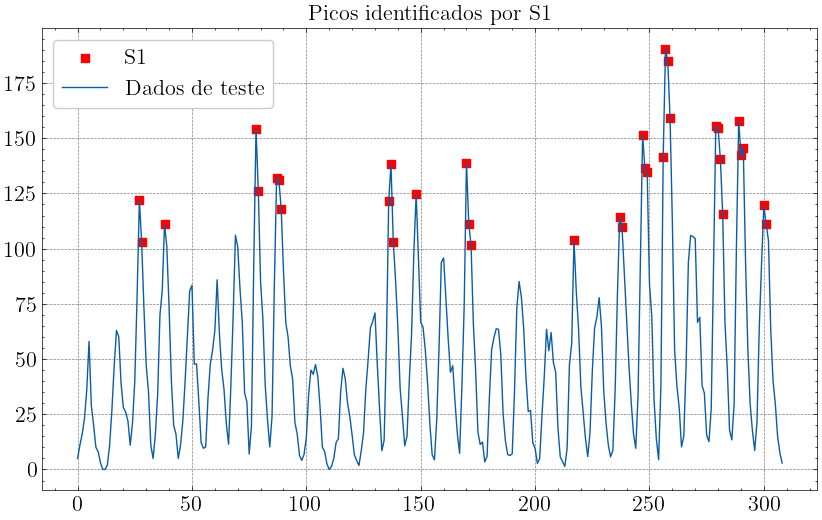

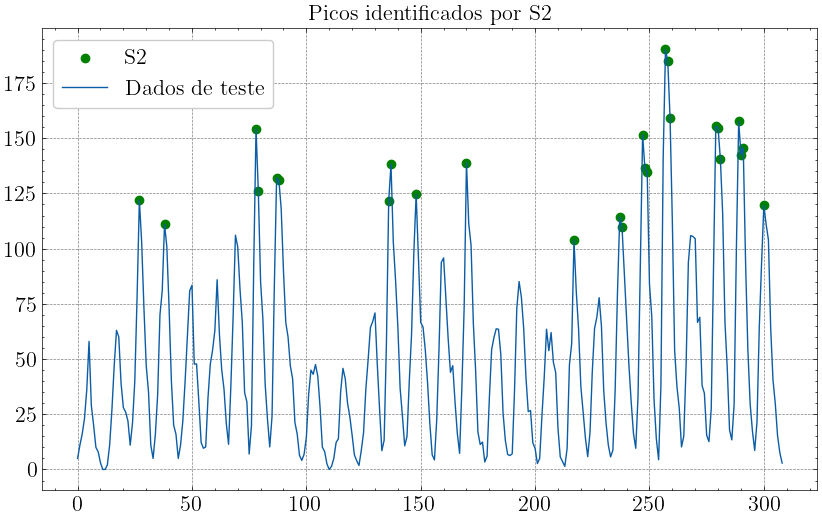

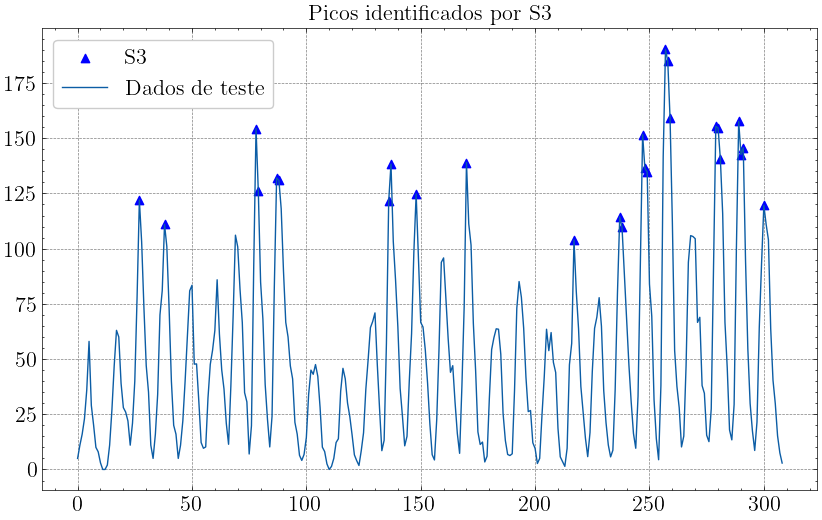

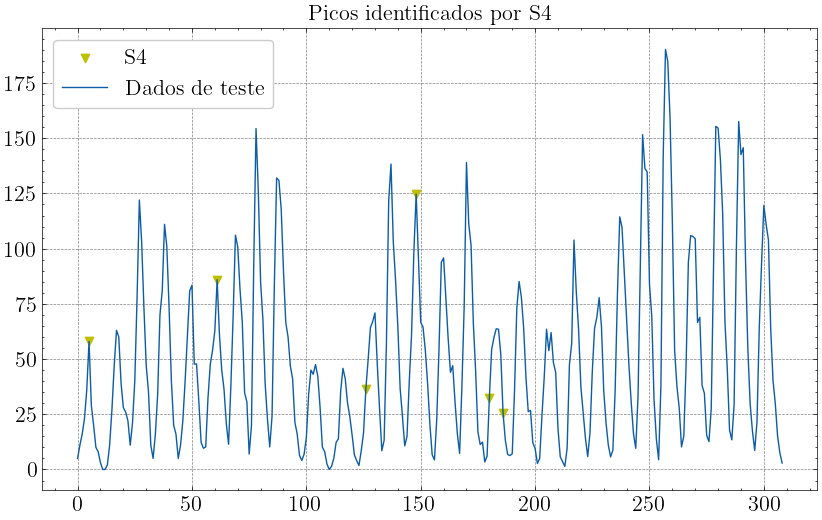

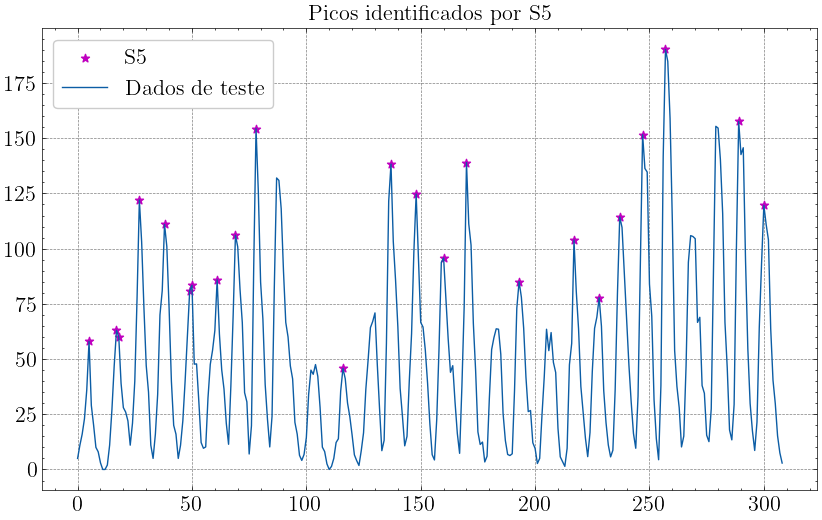

In [39]:
# Calcula média e desvio padrão de S1
s1_sunspots_mean = np.mean(s1_sunspots, axis=0)
s1_sunspots_std = np.std(s1_sunspots)
#
# Calcula média e desvio padrão de S2
s2_sunspots_mean = np.mean(s2_sunspots, axis=0)
s2_sunspots_std = np.std(s2_sunspots)
#
# Calcula média e desvio padrão de S3
s3_sunspots_mean = np.mean(s3_sunspots, axis=0)
s3_sunspots_std = np.std(s3_sunspots)
#
# Calcula média e desvio padrão de S4
s4_sunspots_mean = np.mean(s4_sunspots, axis=0)
s4_sunspots_std = np.std(s4_sunspots)


# Obtém índices dos picos (3 desvios padrão acima da média)
#
# S1
s1_is_peak = np.where(s1_sunspots > s1_sunspots_mean + h_sunspots*s1_sunspots_std, True, False)
s1_peak_indexes = [i for (i, value) in enumerate(s1_is_peak) if value]
#
# S2
s2_is_peak = np.where(s2_sunspots > s2_sunspots_mean + h_sunspots*s2_sunspots_std, True, False)
s2_peak_indexes = [i for (i, value) in enumerate(s2_is_peak) if value]
#
# S3
s3_is_peak = np.where(s3_sunspots > s3_sunspots_mean + h_sunspots*s3_sunspots_std, True, False)
s3_peak_indexes = [i for (i, value) in enumerate(s3_is_peak) if value]
#
# S4
s4_is_peak = np.where(s4_sunspots > s4_sunspots_mean + h_sunspots*s4_sunspots_std, True, False)
s4_peak_indexes = [i for (i, value) in enumerate(s4_is_peak) if value]
#
# S5 (não faz verificação da distância em relação à média, pois já é feito na definição da métrica)
s5_peak_indexes = [i for (i, value) in enumerate(s5_sunspots_is_outlier.values.flatten()) if value]

# Marcar no gráfico os picos identificados por cada métrica
#
# S1
plt.scatter(s1_peak_indexes, sunspots.values[s1_peak_indexes], marker='s', color='r', label='S1')
#
# Plotar gráfico com os picos identificados
plt.plot(sunspots.values, label='Dados de teste')
plt.title(f'Picos identificados por S1')
plt.legend(frameon=True)
plt.show()
#
# S2
plt.scatter(s2_peak_indexes, sunspots.values[s2_peak_indexes], marker='o', color='g', label='S2')
#
# Plotar gráfico com os picos identificados
plt.plot(sunspots.values, label='Dados de teste')
plt.title(f'Picos identificados por S2')
plt.legend(frameon=True)
plt.show()
#
# S3
plt.scatter(s3_peak_indexes, sunspots.values[s3_peak_indexes], marker='^', color='b', label='S3')
#
# Plotar gráfico com os picos identificados
plt.plot(sunspots.values, label='Dados de teste')
plt.title(f'Picos identificados por S3')
plt.legend(frameon=True)
plt.show()
#
# S4
plt.scatter(s4_peak_indexes, sunspots.values[s4_peak_indexes], marker='v', color='y', label='S4')
#
# Plotar gráfico com os picos identificados
plt.plot(sunspots.values, label='Dados de teste')
plt.title(f'Picos identificados por S4')
plt.legend(frameon=True)
plt.show()
#
# S5
plt.scatter(s5_peak_indexes, sunspots.values[s5_peak_indexes], marker='*', color='m', label='S5')
#
# Plotar gráfico com os picos identificados
plt.plot(sunspots.values, label='Dados de teste')
plt.title(f'Picos identificados por S5')
plt.legend(frameon=True)
plt.show()

---

# Teste em dados reais

In [40]:
# Dados de treino
train_RD = pd.read_csv(f'/home/yanvgf/Projetos/litc/ihm/novelty-detection/arquivos/RD_train_{target}.csv')

# Dados de teste
test_RD = pd.read_csv(f'/home/yanvgf/Projetos/litc/ihm/novelty-detection/arquivos/RD_test_{target}.csv')
target_test = pd.DataFrame(test_RD[target])

NameError: name 'target' is not defined

In [44]:
# Dataset completo
full_dataset_train = pd.read_csv(f'/home/yanvgf/Projetos/litc/ihm/novelty-detection/arquivos/full_train_{target}.csv')
full_dataset_test = pd.read_csv(f'/home/yanvgf/Projetos/litc/ihm/novelty-detection/arquivos/full_test_{target}.csv')

# Dataset apenas com duplicatas removidas, siConL1
train_RD = pd.read_csv(f'/home/yanvgf/Projetos/litc/ihm/novelty-detection/arquivos/RD_train_{target}.csv')
test_RD = pd.read_csv(f'/home/yanvgf/Projetos/litc/ihm/novelty-detection/arquivos/RD_test_{target}.csv')

# Vou manter as datas do conjunto de dados para facilitar a organização após a seleção de amostras
index_train = train_RD.iloc[:,0]
train_RD = train_RD.iloc[:,1:]
index_test = test_RD.iloc[:,0]
test_RD = test_RD.iloc[:,1:]

# Renomeando e transformando coluna de datas em index dos dataframes
#
# Treinamento
reference_points = train_RD
reference_points.index = np.array([datetime.strptime(data_str, '%Y-%m-%d %H:%M:%S') for data_str in index_train])
#
full_train_time, full_dataset_train = (full_dataset_train[full_dataset_train.columns.values[0]], full_dataset_train[full_dataset_train.columns.values[1:]])
full_train_time = pd.to_datetime(full_train_time.values)
full_dataset_train.index = full_train_time
#
# Teste
test_points = test_RD
test_points.index = np.array([datetime.strptime(data_str, '%Y-%m-%d %H:%M:%S') for data_str in index_test])
#
full_test_time, full_dataset_test = (full_dataset_test[full_dataset_test.columns.values[0]], full_dataset_test[full_dataset_test.columns.values[1:]])
full_test_time = pd.to_datetime(full_test_time.values)
full_dataset_test.index = full_test_time

# Separação das variáveis em variáveis químicas em variáveis de processo
var2h, var1min = NomesDasVariaveis.getVariablesNames(full_dataset_train)
var2h = list(set(var2h).intersection(set(full_dataset_train.columns.values)))

não há Data_Fim
não há Unnamed: 0


### Geração dos dados deslocados etc.

In [45]:
# Identificando todas as amostras válidas de treino e teste
sampling_dates_train = np.array([data for data in pre_processing.datetime64_to_datetime(pd.DataFrame(full_dataset_train.index.values)) if pre_processing.is_laboratory_sampling_time(data, minutes=1)])
sampling_dates_test = np.array([data for data in pre_processing.datetime64_to_datetime(pd.DataFrame(full_dataset_test.index.values)) if pre_processing.is_laboratory_sampling_time(data, minutes=1)])

# Obtém início e fim de períodos contínuos
continuous_train = pre_processing.get_continuous_windows(pd.DataFrame(sampling_dates_train),
                                                                sampling_scale='hours',
                                                                sampling_gap=2)
# Obtém início e fim de períodos contínuos
continuous_test = pre_processing.get_continuous_windows(pd.DataFrame(sampling_dates_test),
                                                                sampling_scale='hours',
                                                                sampling_gap=2)

# Tratamento final (deslocamentos e interpolação, considerando as descontinuidades)
final_train_original = pre_processing.treat_discontinuities(full_dataset_train, 
                                                            continuous_train,
                                                            target,
                                                            pd.DataFrame(var2h),
                                                            data_shift=120,
                                                            interpolate=True,
                                                            get_naive=False)
final_test, naive = pre_processing.treat_discontinuities(full_dataset_test, 
                                                                continuous_test,
                                                                target,
                                                                pd.DataFrame(var2h),
                                                                data_shift=1,
                                                                interpolate=False,
                                                                get_naive=True)

In [46]:
# Calcula as métricas S1, S2 e S3 para o conjunto de teste
#
# k = 6 porque as amostras são coletadas de 2h em 2h, então consigo comparar cada amostra com o dia em que ela foi coletada
k = 6
h_test = 1.5
s1_test = s1_metric(pd.DataFrame(final_test[target].reset_index(drop=True)), k)
s2_test = s2_metric(pd.DataFrame(final_test[target].reset_index(drop=True)), k)
s3_test = s3_metric(pd.DataFrame(final_test[target].reset_index(drop=True)), k)
s4_test = s4_metric(pd.DataFrame(final_test[target].reset_index(drop=True)), k, bandwidth=0.1, kde_kernel='gaussian')
s5_test = s5_metric(pd.DataFrame(final_test[target].reset_index(drop=True)), k, method='parametric', n_std=h_test)

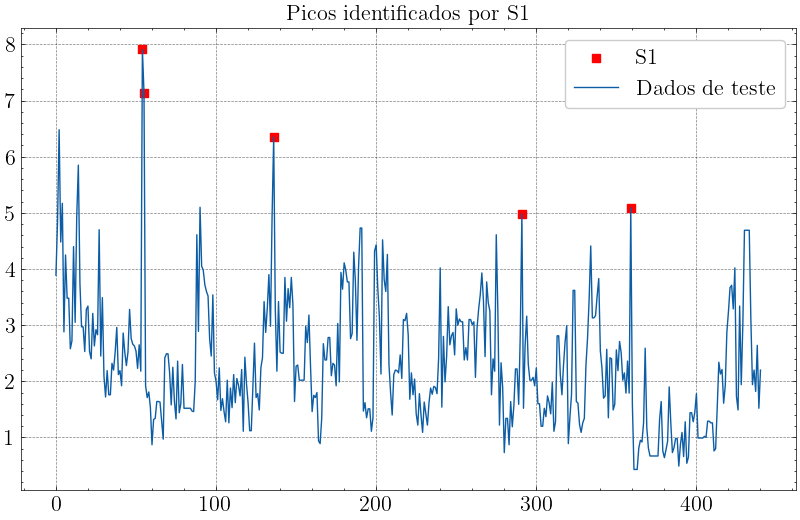

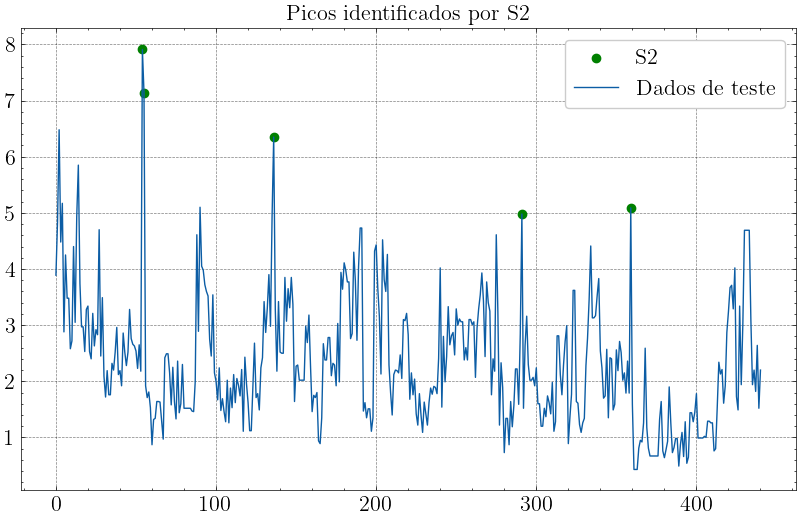

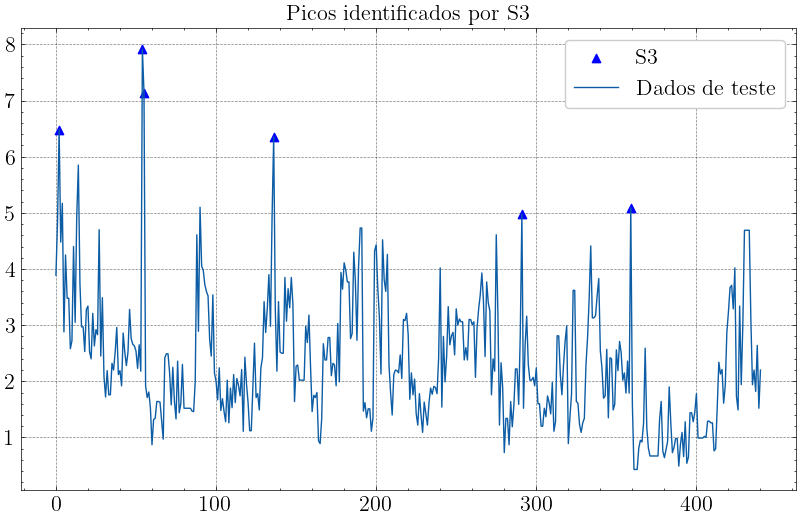

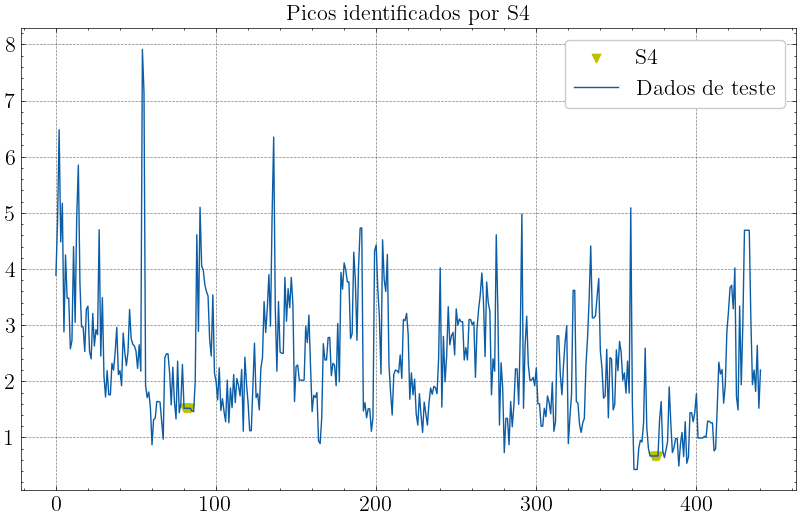

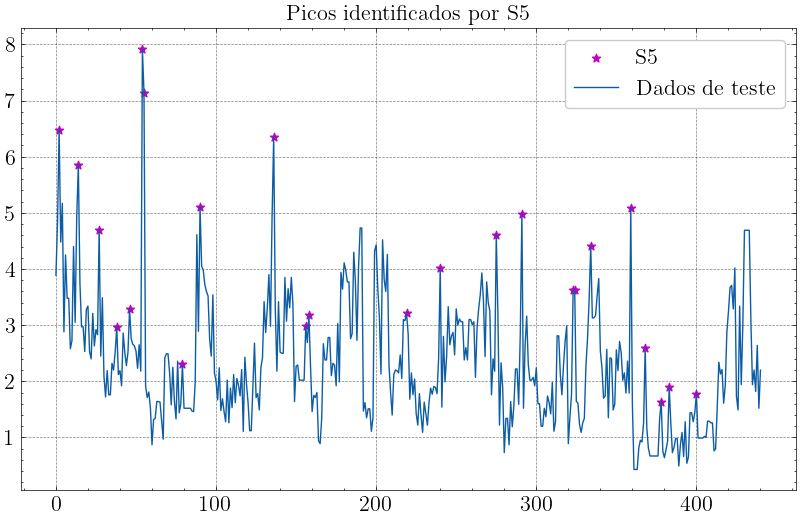

In [47]:
# Calcula média e desvio padrão de S1
s1_test_mean = np.mean(s1_test, axis=0)
s1_test_std = np.std(s1_test)
#
# Calcula média e desvio padrão de S2
s2_test_mean = np.mean(s2_test, axis=0)
s2_test_std = np.std(s2_test)
#
# Calcula média e desvio padrão de S3
s3_test_mean = np.mean(s3_test, axis=0)
s3_test_std = np.std(s3_test)
#
# Calcula média e desvio padrão de S4
s4_test_mean = np.mean(s4_test, axis=0)
s4_test_std = np.std(s4_test)
#
# Calcula média e desvio padrão de S5
s5_test_mean = np.mean(s5_test, axis=0)
s5_test_std = np.std(s5_test)


# Obtém índices dos picos (3 desvios padrão acima da média)
#
# S1
s1_is_peak = np.where(s1_test > s1_test_mean + 3*s1_test_std, True, False)
s1_peak_indexes = [i for (i, value) in enumerate(s1_is_peak) if value]
#
# S2
s2_is_peak = np.where(s2_test > s2_test_mean + 3*s2_test_std, True, False)
s2_peak_indexes = [i for (i, value) in enumerate(s2_is_peak) if value]
#
# S3
s3_is_peak = np.where(s3_test > s3_test_mean + 3*s3_test_std, True, False)
s3_peak_indexes = [i for (i, value) in enumerate(s3_is_peak) if value]
#
# S4
s4_is_peak = np.where(s4_test > s4_test_mean + 3*s4_test_std, True, False)
s4_peak_indexes = [i for (i, value) in enumerate(s4_is_peak) if value]
#
# S5
s5_peak_indexes = [i for (i, value) in enumerate(s5_test.values.flatten()) if value]

# Marcar no gráfico os picos identificados por cada métrica
#
# S1
plt.scatter(s1_peak_indexes, final_test[target].values[s1_peak_indexes], marker='s', color='r', label='S1')
#
# Plotar gráfico com os picos identificados
plt.plot(final_test[target].values, label='Dados de teste')
plt.title(f'Picos identificados por S1')
plt.legend(frameon=True)
plt.show()

# S2
plt.scatter(s2_peak_indexes, final_test[target].values[s2_peak_indexes], marker='o', color='g', label='S2')
#
# Plotar gráfico com os picos identificados
plt.plot(final_test[target].values, label='Dados de teste')
plt.title(f'Picos identificados por S2')
plt.legend(frameon=True)
plt.show()

# S3
plt.scatter(s3_peak_indexes, final_test[target].values[s3_peak_indexes], marker='^', color='b', label='S3')
#
# Plotar gráfico com os picos identificados
plt.plot(final_test[target].values, label='Dados de teste')
plt.title(f'Picos identificados por S3')
plt.legend(frameon=True)
plt.show()

# S4
plt.scatter(s4_peak_indexes, final_test[target].values[s4_peak_indexes], marker='v', color='y', label='S4')
#
# Plotar gráfico com os picos identificados
plt.plot(final_test[target].values, label='Dados de teste')
plt.title(f'Picos identificados por S4')
plt.legend(frameon=True)
plt.show()

# S5
plt.scatter(s5_peak_indexes, final_test[target].values[s5_peak_indexes], marker='*', color='m', label='S5')
#
# Plotar gráfico com os picos identificados
plt.plot(final_test[target].values, label='Dados de teste')
plt.title(f'Picos identificados por S5')
plt.legend(frameon=True)
plt.show()

# Avaliação do modelo nos pontos identificados como picos

### 1. Obtenção do erro do modelo em toda a série

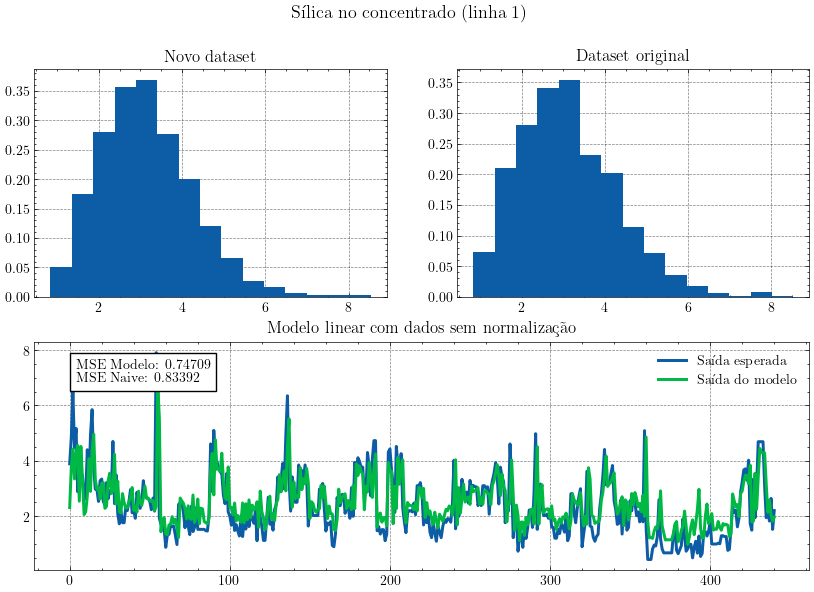

In [74]:
# Geração do modelo
yhat_original, mse_original, _ = models.adaline(final_train_original.loc[:,final_train_original.columns.values!=target].reset_index(drop=True),
                                        final_train_original.loc[:,target].reset_index(drop=True),
                                        final_test.loc[:,final_test.columns.values!=target].reset_index(drop=True),
                                        final_test.loc[:,target].reset_index(drop=True))

# Plot dos resultados
mse, mseNaive, pesosPerceptron = models.evaluate_model(final_train_original, final_test, train_RD, naive,
                                                       target, feature_set=final_train_original.columns,
                                                       norm=0, plot=1)

### 2. Obtenção do erro do modelo nos pontos identificados como pico

In [82]:
all_samples_model_squared_error = (yhat_original.values.flatten() - final_test.loc[:,target].values.flatten())**2
without_age_sampling_model_squared_error = pd.read_csv('/home/yanvgf/Projetos/litc/ihm/peak-detection/arquivos/without_age_weighting_model_squared_error.csv').iloc[:,1]
age_sampling_model_squared_error = pd.read_csv('/home/yanvgf/Projetos/litc/ihm/peak-detection/arquivos/age_weighting_model_squared_error.csv').iloc[:,1]
naive_squared_error = (naive.values.flatten() - final_test.loc[:,target].values.flatten())**2

In [83]:
all_samples_model_peak_mse = np.mean(all_samples_model_squared_error[s3_peak_indexes])
without_age_sampling_model_peak_mse = np.mean(without_age_sampling_model_squared_error[s3_peak_indexes])
age_sampling_model_peak_mse = np.mean(age_sampling_model_squared_error[s3_peak_indexes])
naive_peak_mse = np.mean(naive_squared_error[s3_peak_indexes])

In [91]:
all_samples_model_peak_mse

8.81814941173318

In [79]:
without_age_sampling_model_peak_mse

8.91342476495567

In [80]:
age_sampling_model_peak_mse

9.070550969608359